# Clustering Analysis
This notebook performs clustering analysis on survey data using K-Means for clustering and UMAP for visualization. The analysis creates two key visualizations:

1. K-Means clustering directly on the data, then visualized with UMAP
2. Program type distribution visualized with UMAP

## 1. Import Libraries and Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Set global plotting parameters
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Loading and Preprocessing

In [2]:
# Load data
def load_and_preprocess_data():
    # Load original data with labels
    data = pd.read_stata("../Data/V1_qualflags_analysis2_ML.dta")
    df, meta = pyreadstat.read_dta("../Data/V1_qualflags_analysis2_ML.dta")
    variable_labels = dict(zip(data.columns, meta.column_labels))
    
    # Save program types for later comparison
    program_types = data['program'].copy()
    
    # Create dummy variables
    data_dummies = pd.get_dummies(data)
    
    # Clean column names
    new_cols = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_') 
                for col in data_dummies.columns]
    data_dummies.columns = new_cols
    
    # Handle missing values
    # Fill numeric columns with median
    numeric_cols = data_dummies.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        data_dummies[col] = data_dummies[col].fillna(data_dummies[col].median())
    
    # Fill non-numeric columns with mode
    non_numeric_cols = data_dummies.select_dtypes(exclude=['float64', 'int64']).columns
    for col in non_numeric_cols:
        if not data_dummies[col].mode().empty:
            data_dummies[col] = data_dummies[col].fillna(data_dummies[col].mode()[0])
        else:
            data_dummies[col] = data_dummies[col].fillna(0)
    
    # Standardize features for clustering
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_dummies)
    
    print(f"Original data shape: {data.shape}")
    print(f"Processed data shape: {data_dummies.shape}")
    
    return data, data_dummies, data_scaled, program_types, variable_labels

# Load and preprocess data
data, data_dummies, data_scaled, program_types, variable_labels = load_and_preprocess_data()

Original data shape: (1209, 466)
Processed data shape: (1209, 760)


## 3. Perform K-Means Clustering Directly on Data

In [3]:
# Perform K-Means clustering on the scaled data
def perform_kmeans_clustering(data_scaled, n_clusters_list=[2, 3]):
    clustering_results = {}
    
    for n_clusters in n_clusters_list:
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data_scaled)
        
        # Calculate silhouette score
        silhouette = silhouette_score(data_scaled, cluster_labels)
        
        # Store results
        clustering_results[n_clusters] = {
            'labels': cluster_labels,
            'model': kmeans,
            'silhouette': silhouette
        }
        
        print(f"\nK-Means clustering with {n_clusters} clusters:")
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Cluster distribution:")
        print(pd.Series(cluster_labels).value_counts().sort_index())
    
    return clustering_results

# Perform clustering for both k=2 and k=3
clustering_results = perform_kmeans_clustering(data_scaled)


K-Means clustering with 2 clusters:
Silhouette Score: 0.028
Cluster distribution:
0    784
1    425
Name: count, dtype: int64

K-Means clustering with 3 clusters:
Silhouette Score: 0.028
Cluster distribution:
0    313
1    503
2    393
Name: count, dtype: int64


## 4. Apply UMAP for Visualization

In [4]:
# Apply UMAP for visualization
def apply_umap_for_visualization(data_scaled):
    # UMAP for dimensionality reduction (for visualization only)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(data_scaled)
    
    print(f"UMAP embedding shape: {embedding.shape}")
    return embedding

# Get UMAP embedding
umap_embedding = apply_umap_for_visualization(data_scaled)

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1209, 2)


## 5. Visualize Clusters with UMAP

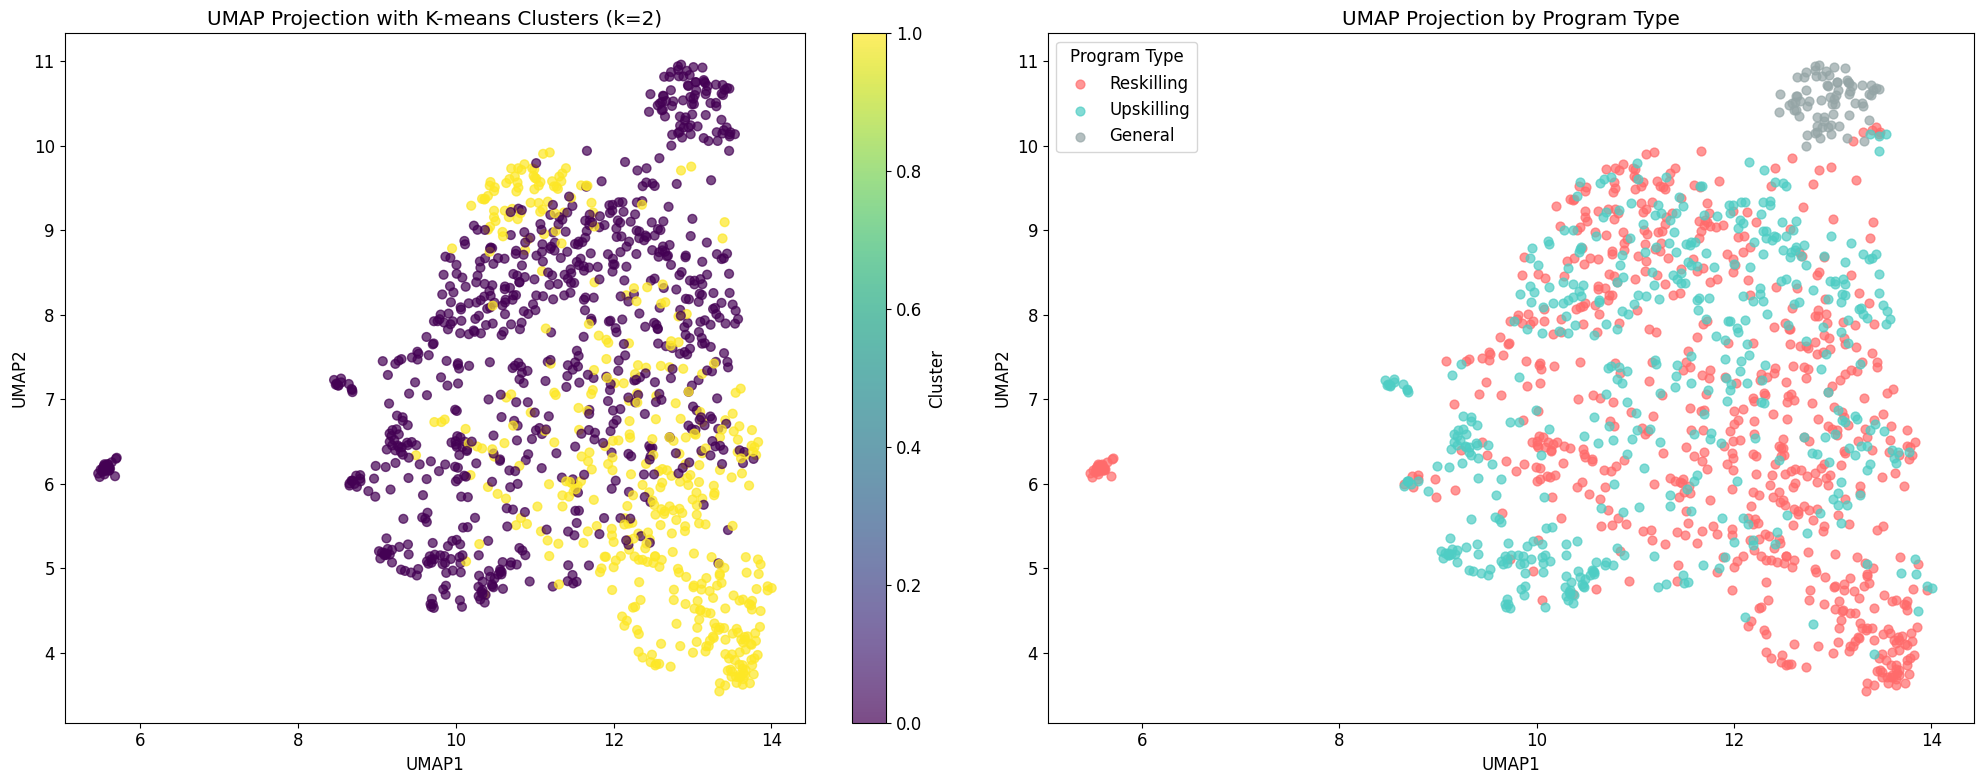

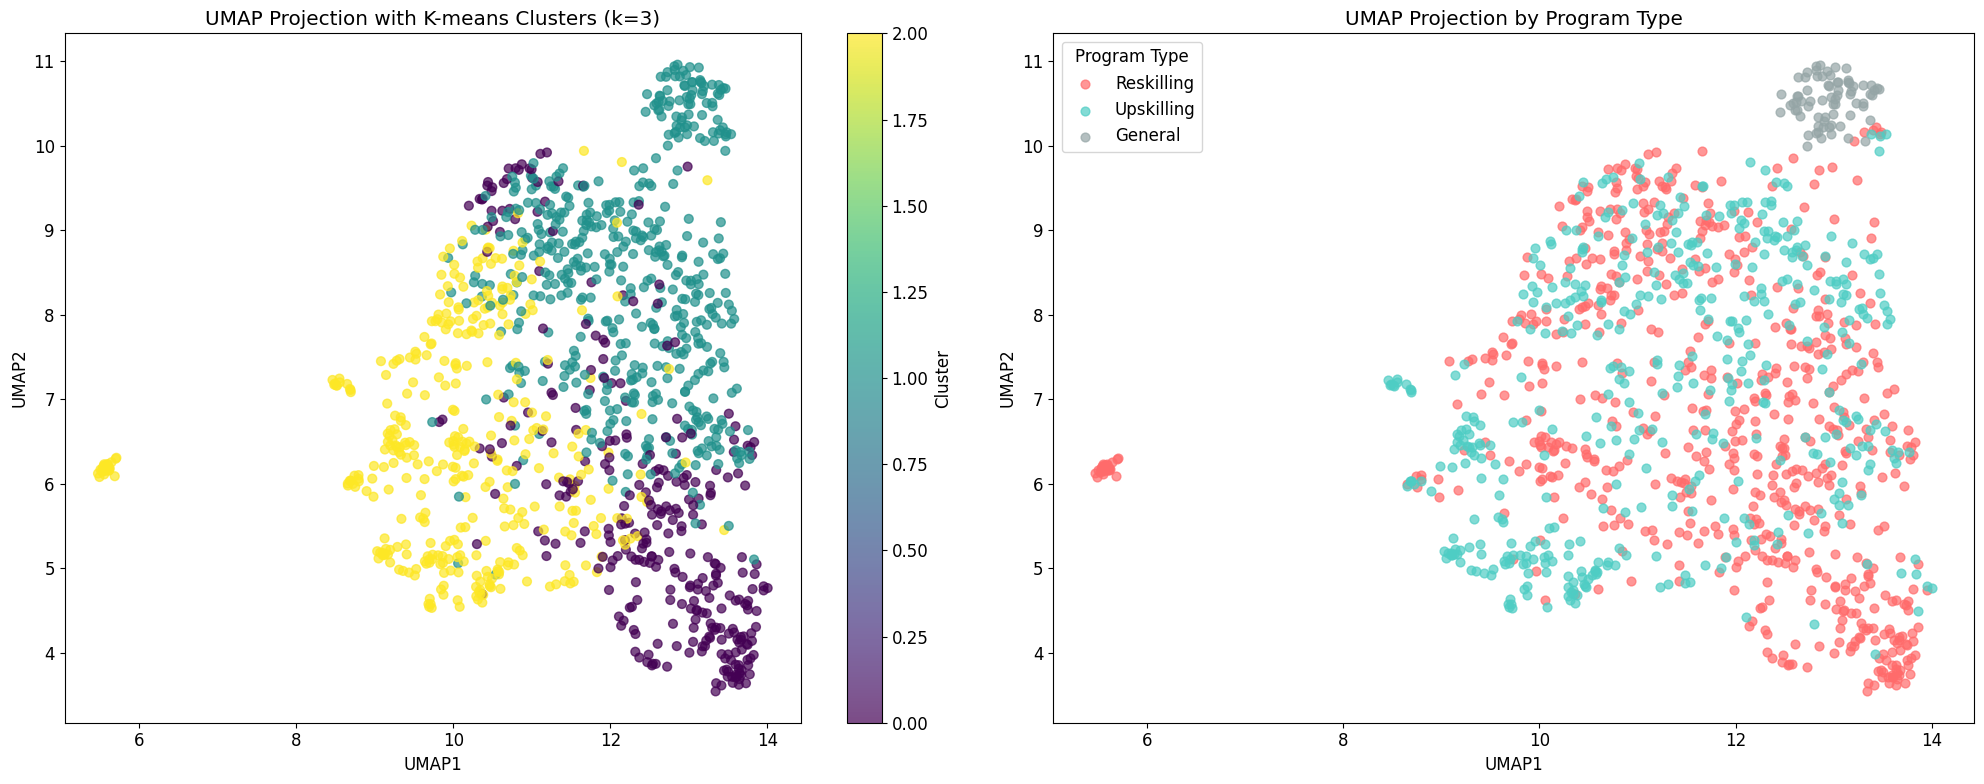

In [5]:
# Visualize clusters using UMAP
def visualize_clusters_with_umap(embedding, cluster_labels, n_clusters, program_types=None):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: K-means clusters
    scatter1 = ax1.scatter(embedding[:, 0], embedding[:, 1], 
                          c=cluster_labels, cmap='viridis',
                          alpha=0.7, s=40)
    ax1.set_title(f'UMAP Projection with K-means Clusters (k={n_clusters})')
    ax1.set_xlabel('UMAP1')
    ax1.set_ylabel('UMAP2')
    plt.colorbar(scatter1, ax=ax1, label='Cluster')
    
    # Plot 2: Program types (if provided)
    if program_types is not None:
        program_colors = {'Reskilling': '#FF6B6B', 'Upskilling': '#4ECDC4', 'General': '#95A5A6'}
        
        for program in program_colors:
            mask = program_types == program
            ax2.scatter(embedding[mask, 0], embedding[mask, 1], 
                       color=program_colors[program], label=program,
                       alpha=0.7, s=40)
        
        ax2.set_title('UMAP Projection by Program Type')
        ax2.set_xlabel('UMAP1')
        ax2.set_ylabel('UMAP2')
        ax2.legend(title='Program Type')
    
    plt.tight_layout()
    plt.savefig(f'umap_clusters_{n_clusters}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize both clustering solutions
for n_clusters in [2, 3]:
    visualize_clusters_with_umap(
        umap_embedding, 
        clustering_results[n_clusters]['labels'], 
        n_clusters,
        program_types
    )

## 6. Analyze Cluster Composition by Program Type


Program distribution in 2 clusters:


<Figure size 1000x600 with 0 Axes>

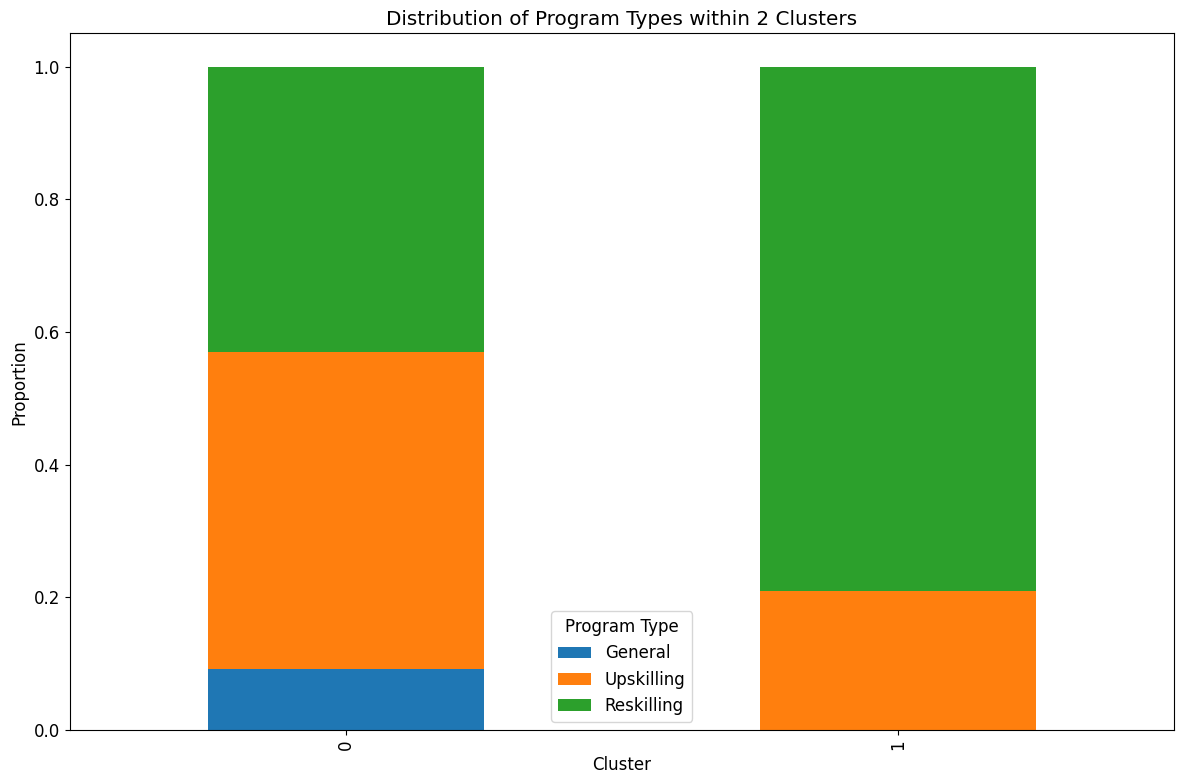

Program   General  Upskilling  Reskilling
Cluster                                  
0        0.091837    0.478316    0.429847
1        0.000000    0.209412    0.790588

Program distribution in 3 clusters:


<Figure size 1000x600 with 0 Axes>

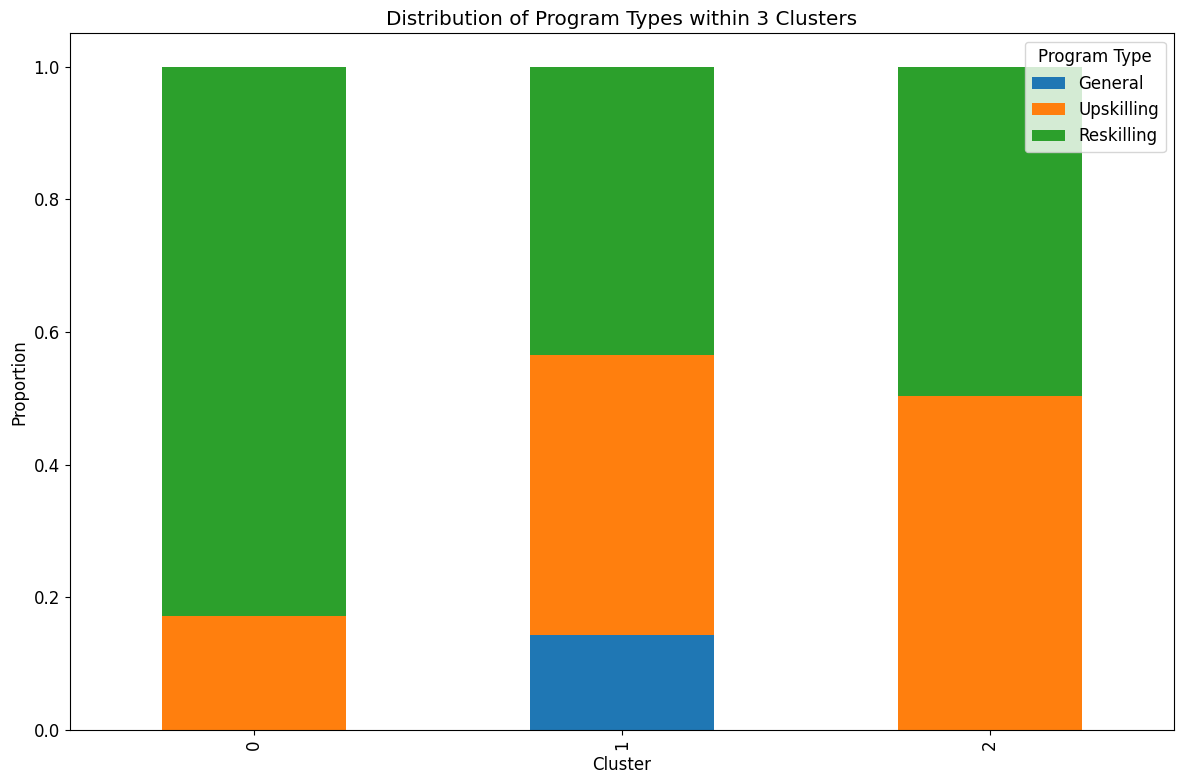

Program   General  Upskilling  Reskilling
Cluster                                  
0        0.000000    0.172524    0.827476
1        0.143141    0.421471    0.435388
2        0.000000    0.503817    0.496183


In [6]:
# Create a confusion matrix to compare clusters with program types
def analyze_cluster_program_distribution(cluster_labels, program_types, n_clusters):
    cluster_program_df = pd.DataFrame({
        'Cluster': cluster_labels,
        'Program': program_types.values
    })
    
    # Create confusion matrix
    confusion_matrix = pd.crosstab(
        cluster_program_df['Cluster'],
        cluster_program_df['Program'],
        normalize='index'
    )
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    confusion_matrix.plot(kind='bar', stacked=True)
    plt.title(f'Distribution of Program Types within {n_clusters} Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.legend(title='Program Type')
    plt.tight_layout()
    plt.savefig(f'cluster_program_distribution_{n_clusters}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return confusion_matrix

# Analyze program distribution for both clustering solutions
for n_clusters in [2, 3]:
    print(f"\nProgram distribution in {n_clusters} clusters:")
    confusion_matrix = analyze_cluster_program_distribution(
        clustering_results[n_clusters]['labels'], 
        program_types,
        n_clusters
    )
    print(confusion_matrix)

## 7. Create Feature Importance Visualization


Top differentiating features for 2 clusters:


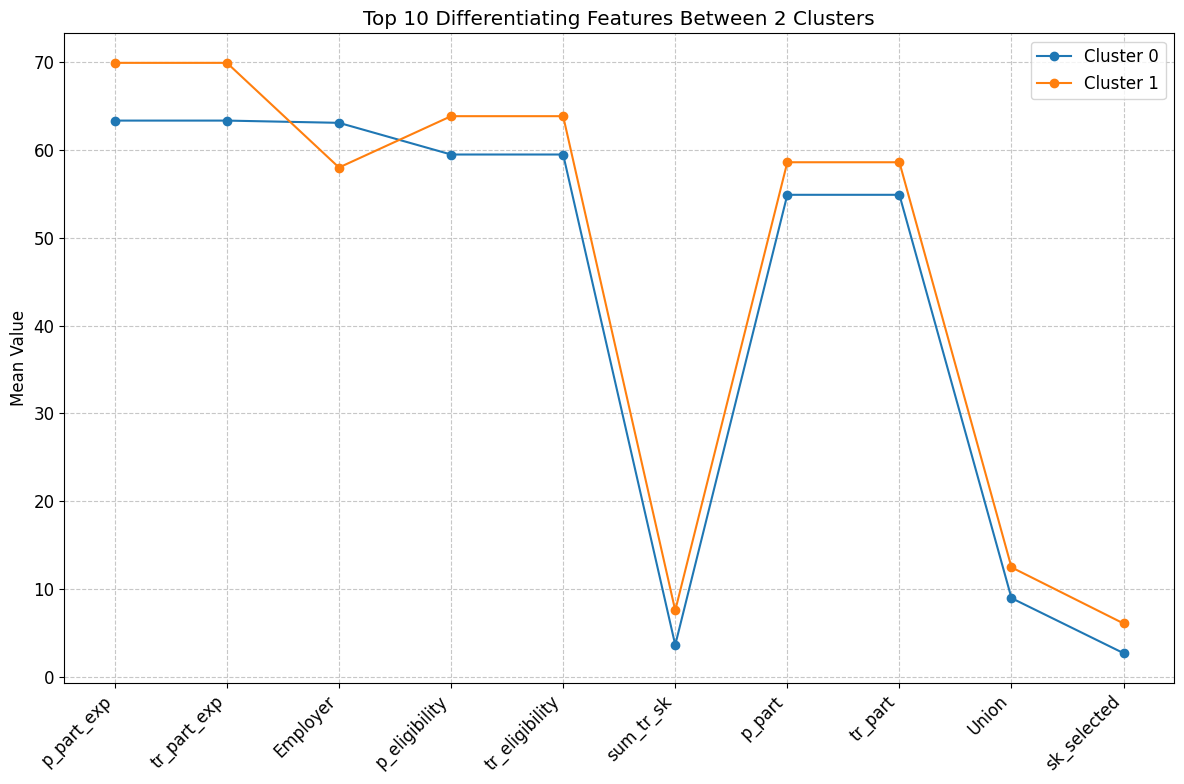


Top differentiating features for 3 clusters:


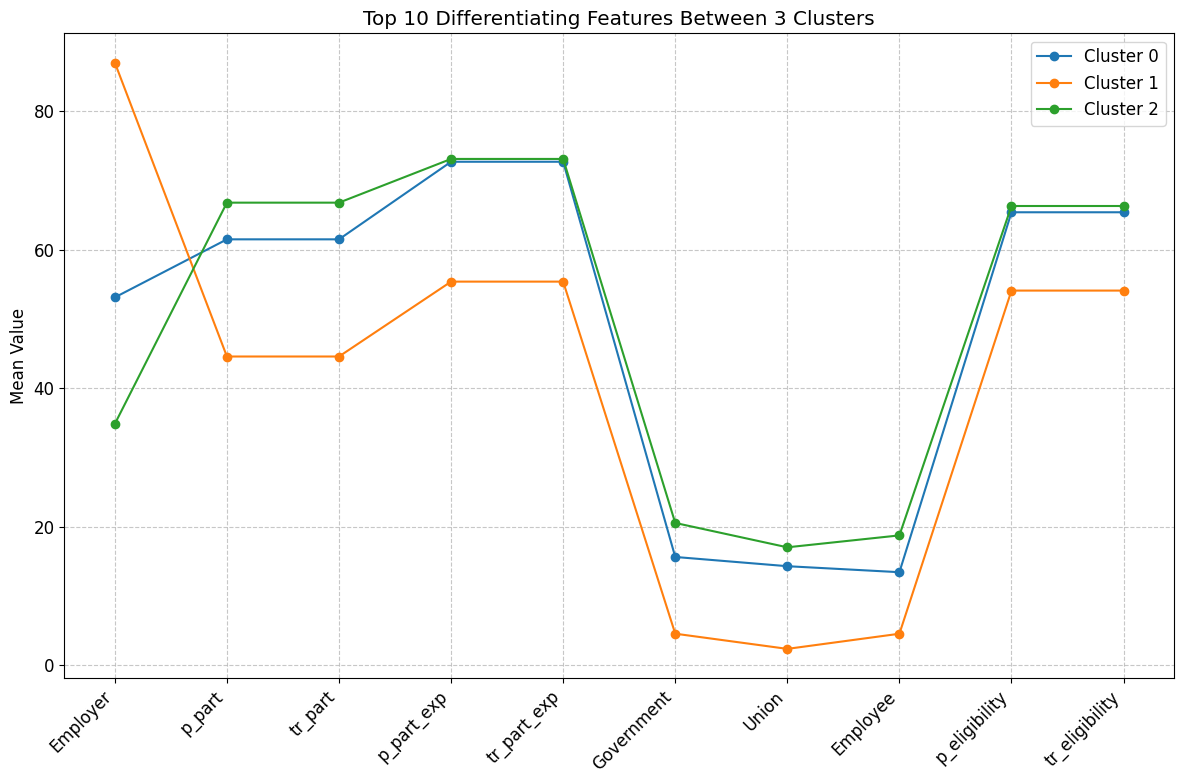

In [7]:
# Analyze which features are most important for defining each cluster
def analyze_feature_importance(data_dummies, cluster_labels, n_clusters, variable_labels, top_n=10):
    # Create a dataframe with the data and cluster labels
    df_with_clusters = data_dummies.copy()
    df_with_clusters['cluster'] = cluster_labels
    
    # Calculate feature means by cluster
    cluster_means = {}
    
    for cluster in range(n_clusters):
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster]
        cluster_means[cluster] = cluster_data.mean()
    
    # Convert to dataframe for easier handling
    means_df = pd.DataFrame(cluster_means)
    
    # Calculate the variance of means across clusters
    means_df['variance'] = means_df.var(axis=1)
    
    # Get top N features with highest variance
    top_features = means_df.nlargest(top_n, 'variance').index.tolist()
    
    # Create a feature comparison plot
    plt.figure(figsize=(12, 8))
    
    for cluster in range(n_clusters):
        values = [means_df.loc[feature, cluster] for feature in top_features]
        plt.plot(range(len(top_features)), values, marker='o', linestyle='-', label=f'Cluster {cluster}')
    
    # Replace feature names with labels if available
    feature_labels = []
    for feature in top_features:
        if feature in variable_labels and variable_labels[feature]:
            feature_labels.append(variable_labels[feature])
        else:
            feature_labels.append(feature)
    
    plt.xticks(range(len(top_features)), feature_labels, rotation=45, ha='right')
    plt.title(f'Top {top_n} Differentiating Features Between {n_clusters} Clusters')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'feature_importance_{n_clusters}_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return top_features, means_df

# Analyze feature importance for both clustering solutions
for n_clusters in [2, 3]:
    print(f"\nTop differentiating features for {n_clusters} clusters:")
    top_features, means_df = analyze_feature_importance(
        data_dummies, 
        clustering_results[n_clusters]['labels'],
        n_clusters,
        variable_labels
    )

## 8. Export Final Results

In [8]:
# Export final results
def export_results(data_dummies, clustering_results, program_types):
    for n_clusters in [2, 3]:
        # Create final dataset with cluster assignments
        result_df = data_dummies.copy()
        result_df['KMeans_Cluster'] = clustering_results[n_clusters]['labels']
        result_df['Program_Type'] = program_types.values
        
        # Export to CSV
        result_df.to_csv(f'cluster_results_{n_clusters}.csv', index=False)
        
        print(f"Results exported to cluster_results_{n_clusters}.csv")

# Export final results
export_results(data_dummies, clustering_results, program_types)

Results exported to cluster_results_2.csv
Results exported to cluster_results_3.csv


## 9. Evaluate Cluster Performance Against Program Types


Cluster to Program Type Matching (k=2):
Accuracy: 0.35
True Positives (Reskilling correctly identified): 337
True Negatives (Upskilling correctly identified): 89
False Positives (Upskilling classified as Reskilling): 447
False Negatives (Reskilling classified as Upskilling): 336

Confusion Matrix:
                    Predicted: Cluster 0  Predicted: Cluster 1
Actual: Upskilling                    89                   447
Actual: Reskilling                   336                   337


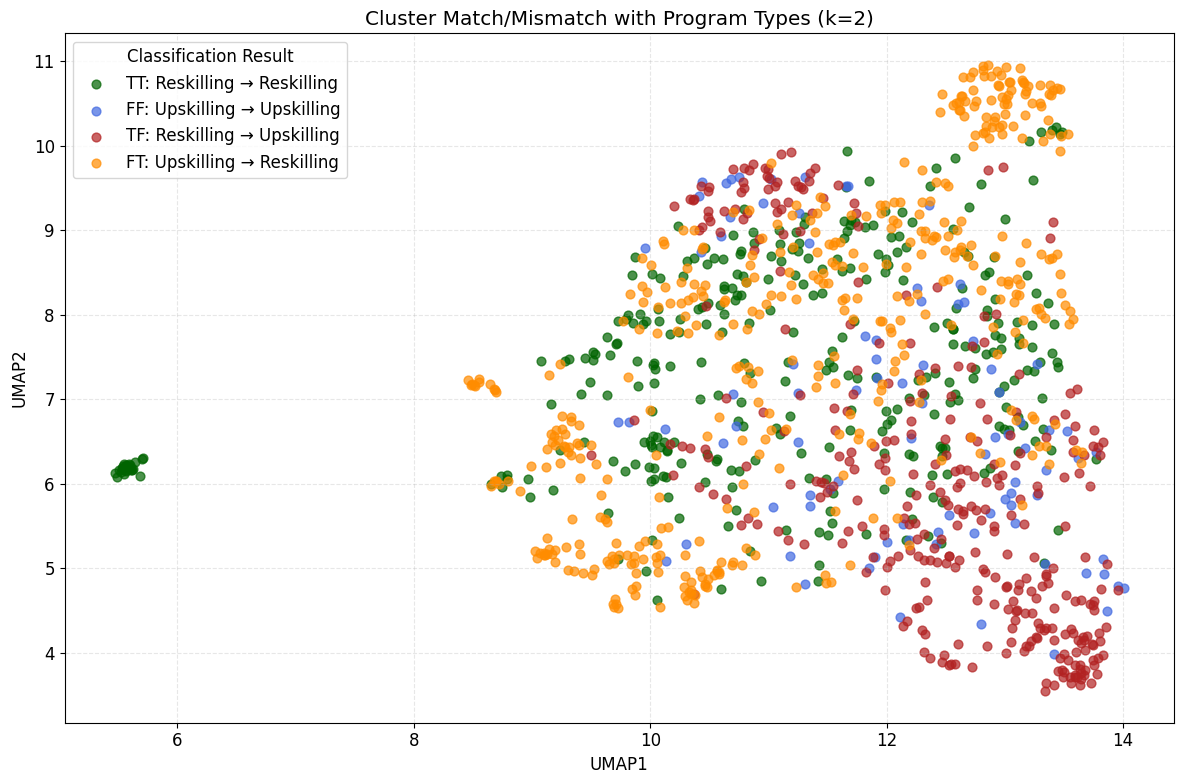


Cluster to Program Type Matching (k=3):
Adjusted Rand Index: 0.0338
(Values close to 1 indicate better clustering alignment with program types)

Program distribution across clusters:
Cluster           0    1    2
Actual Program               
General           0   72    0
Upskilling       54  212  198
Reskilling      259  219  195


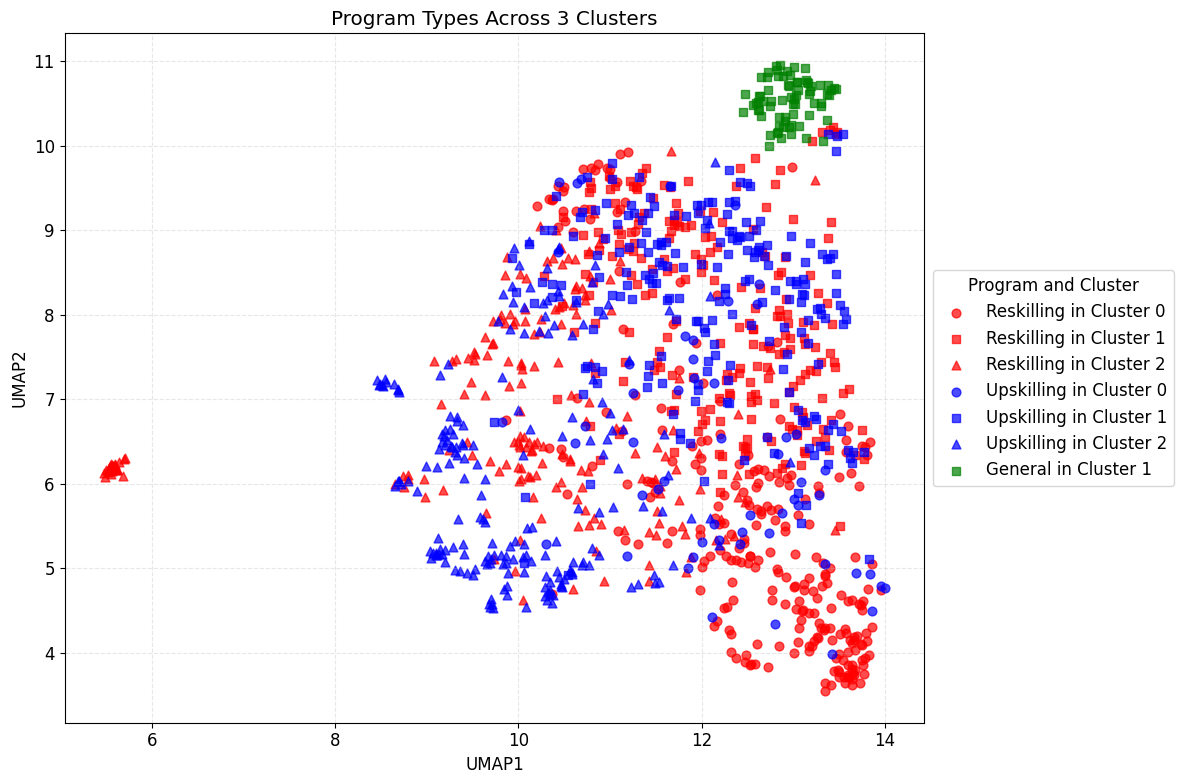

In [10]:
# Evaluate how well clusters match with actual program types
def evaluate_clusters_against_programs(cluster_labels, program_types, n_clusters):
    from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score
    
    # Create binary labels for program types (Reskilling = 1, Others = 0)
    binary_program = np.where(program_types == 'Reskilling', 1, 0)
    
    # For k=2, we can directly compare with binary program types
    if n_clusters == 2:
        # Check if cluster 0 corresponds to Reskilling or Upskilling
        # We may need to flip labels for better comparison
        cluster0_reskilling_count = np.sum((cluster_labels == 0) & (binary_program == 1))
        cluster0_upskilling_count = np.sum((cluster_labels == 0) & (binary_program == 0))
        
        # If cluster 0 has more Upskilling, flip the labels for comparison
        if cluster0_upskilling_count > cluster0_reskilling_count:
            compare_labels = 1 - cluster_labels  # Flip 0->1 and 1->0
        else:
            compare_labels = cluster_labels
            
        # Calculate accuracy
        accuracy = accuracy_score(binary_program, compare_labels)
        
        # Calculate confusion matrix
        cm = confusion_matrix(binary_program, compare_labels)
        
        # Create a dataframe for better visualization
        cm_df = pd.DataFrame(
            cm, 
            index=['Actual: Upskilling', 'Actual: Reskilling'],
            columns=['Predicted: Cluster 0', 'Predicted: Cluster 1']
        )
        
        # Calculate true/false positives/negatives
        tn, fp, fn, tp = cm.ravel()
        
        # Print results
        print(f"\nCluster to Program Type Matching (k={n_clusters}):")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"True Positives (Reskilling correctly identified): {tp}")
        print(f"True Negatives (Upskilling correctly identified): {tn}")
        print(f"False Positives (Upskilling classified as Reskilling): {fp}")
        print(f"False Negatives (Reskilling classified as Upskilling): {fn}")
        print("\nConfusion Matrix:")
        print(cm_df)
        
        # Visualize the comparison
        plt.figure(figsize=(12, 8))
        
        # Create a scatter plot where color shows the match/mismatch
        correct = (binary_program == compare_labels)
        
        # Define categories:
        # TT: True Reskilling classified as Reskilling
        # FF: True Upskilling classified as Upskilling
        # TF: True Reskilling classified as Upskilling
        # FT: True Upskilling classified as Reskilling
        categories = []
        colors = []
        
        for i in range(len(binary_program)):
            if binary_program[i] == 1 and compare_labels[i] == 1:
                categories.append('TT: Reskilling → Reskilling')
                colors.append('darkgreen')
            elif binary_program[i] == 0 and compare_labels[i] == 0:
                categories.append('FF: Upskilling → Upskilling')
                colors.append('royalblue')
            elif binary_program[i] == 1 and compare_labels[i] == 0:
                categories.append('TF: Reskilling → Upskilling')
                colors.append('firebrick')
            else:
                categories.append('FT: Upskilling → Reskilling')
                colors.append('darkorange')
        
        # Convert to arrays for easier plotting
        categories = np.array(categories)
        colors = np.array(colors)
        
        # Plot with UMAP embedding
        for category, color in zip(['TT: Reskilling → Reskilling', 
                                   'FF: Upskilling → Upskilling',
                                   'TF: Reskilling → Upskilling',
                                   'FT: Upskilling → Reskilling'], 
                                  ['darkgreen', 'royalblue', 'firebrick', 'darkorange']):
            mask = categories == category
            if np.any(mask):  # Only plot if we have points in this category
                plt.scatter(
                    umap_embedding[mask, 0], 
                    umap_embedding[mask, 1],
                    c=color,
                    label=category,
                    alpha=0.7,
                    s=40
                )
        
        plt.title(f'Cluster Match/Mismatch with Program Types (k={n_clusters})')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.legend(title='Classification Result')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'cluster_program_match_{n_clusters}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    else:
        # For k=3, we can use Adjusted Rand Index to measure cluster quality
        ari = adjusted_rand_score(program_types, cluster_labels)
        print(f"\nCluster to Program Type Matching (k={n_clusters}):")
        print(f"Adjusted Rand Index: {ari:.4f}")
        print("(Values close to 1 indicate better clustering alignment with program types)")
        
        # Create a crosstab to show distribution
        cm = pd.crosstab(
            program_types,
            cluster_labels,
            rownames=['Actual Program'],
            colnames=['Cluster']
        )
        
        print("\nProgram distribution across clusters:")
        print(cm)
        
        # Visualize the comparison (simplified for k=3)
        plt.figure(figsize=(12, 8))
        
        # Define a color map for the 3-way comparison
        program_colors = {
            'Reskilling': 'red',
            'Upskilling': 'blue',
            'General': 'green'
        }
        
        # Use different marker styles for each cluster
        cluster_markers = {
            0: 'o',  # circle
            1: 's',  # square
            2: '^'   # triangle
        }
        
        # Plot each program type
        for program in program_colors:
            for cluster in range(n_clusters):
                mask = (program_types == program) & (cluster_labels == cluster)
                if np.any(mask):
                    plt.scatter(
                        umap_embedding[mask, 0], 
                        umap_embedding[mask, 1],
                        c=program_colors[program],
                        marker=cluster_markers[cluster],
                        label=f'{program} in Cluster {cluster}',
                        alpha=0.7,
                        s=40
                    )
        
        plt.title(f'Program Types Across {n_clusters} Clusters')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.legend(title='Program and Cluster', loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'program_cluster_distribution_{n_clusters}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
# Evaluate both clustering solutions
for n_clusters in [2, 3]:
    evaluate_clusters_against_programs(
        clustering_results[n_clusters]['labels'],
        program_types,
        n_clusters
    )

## 10. Alternative Clustering Methods Comparison

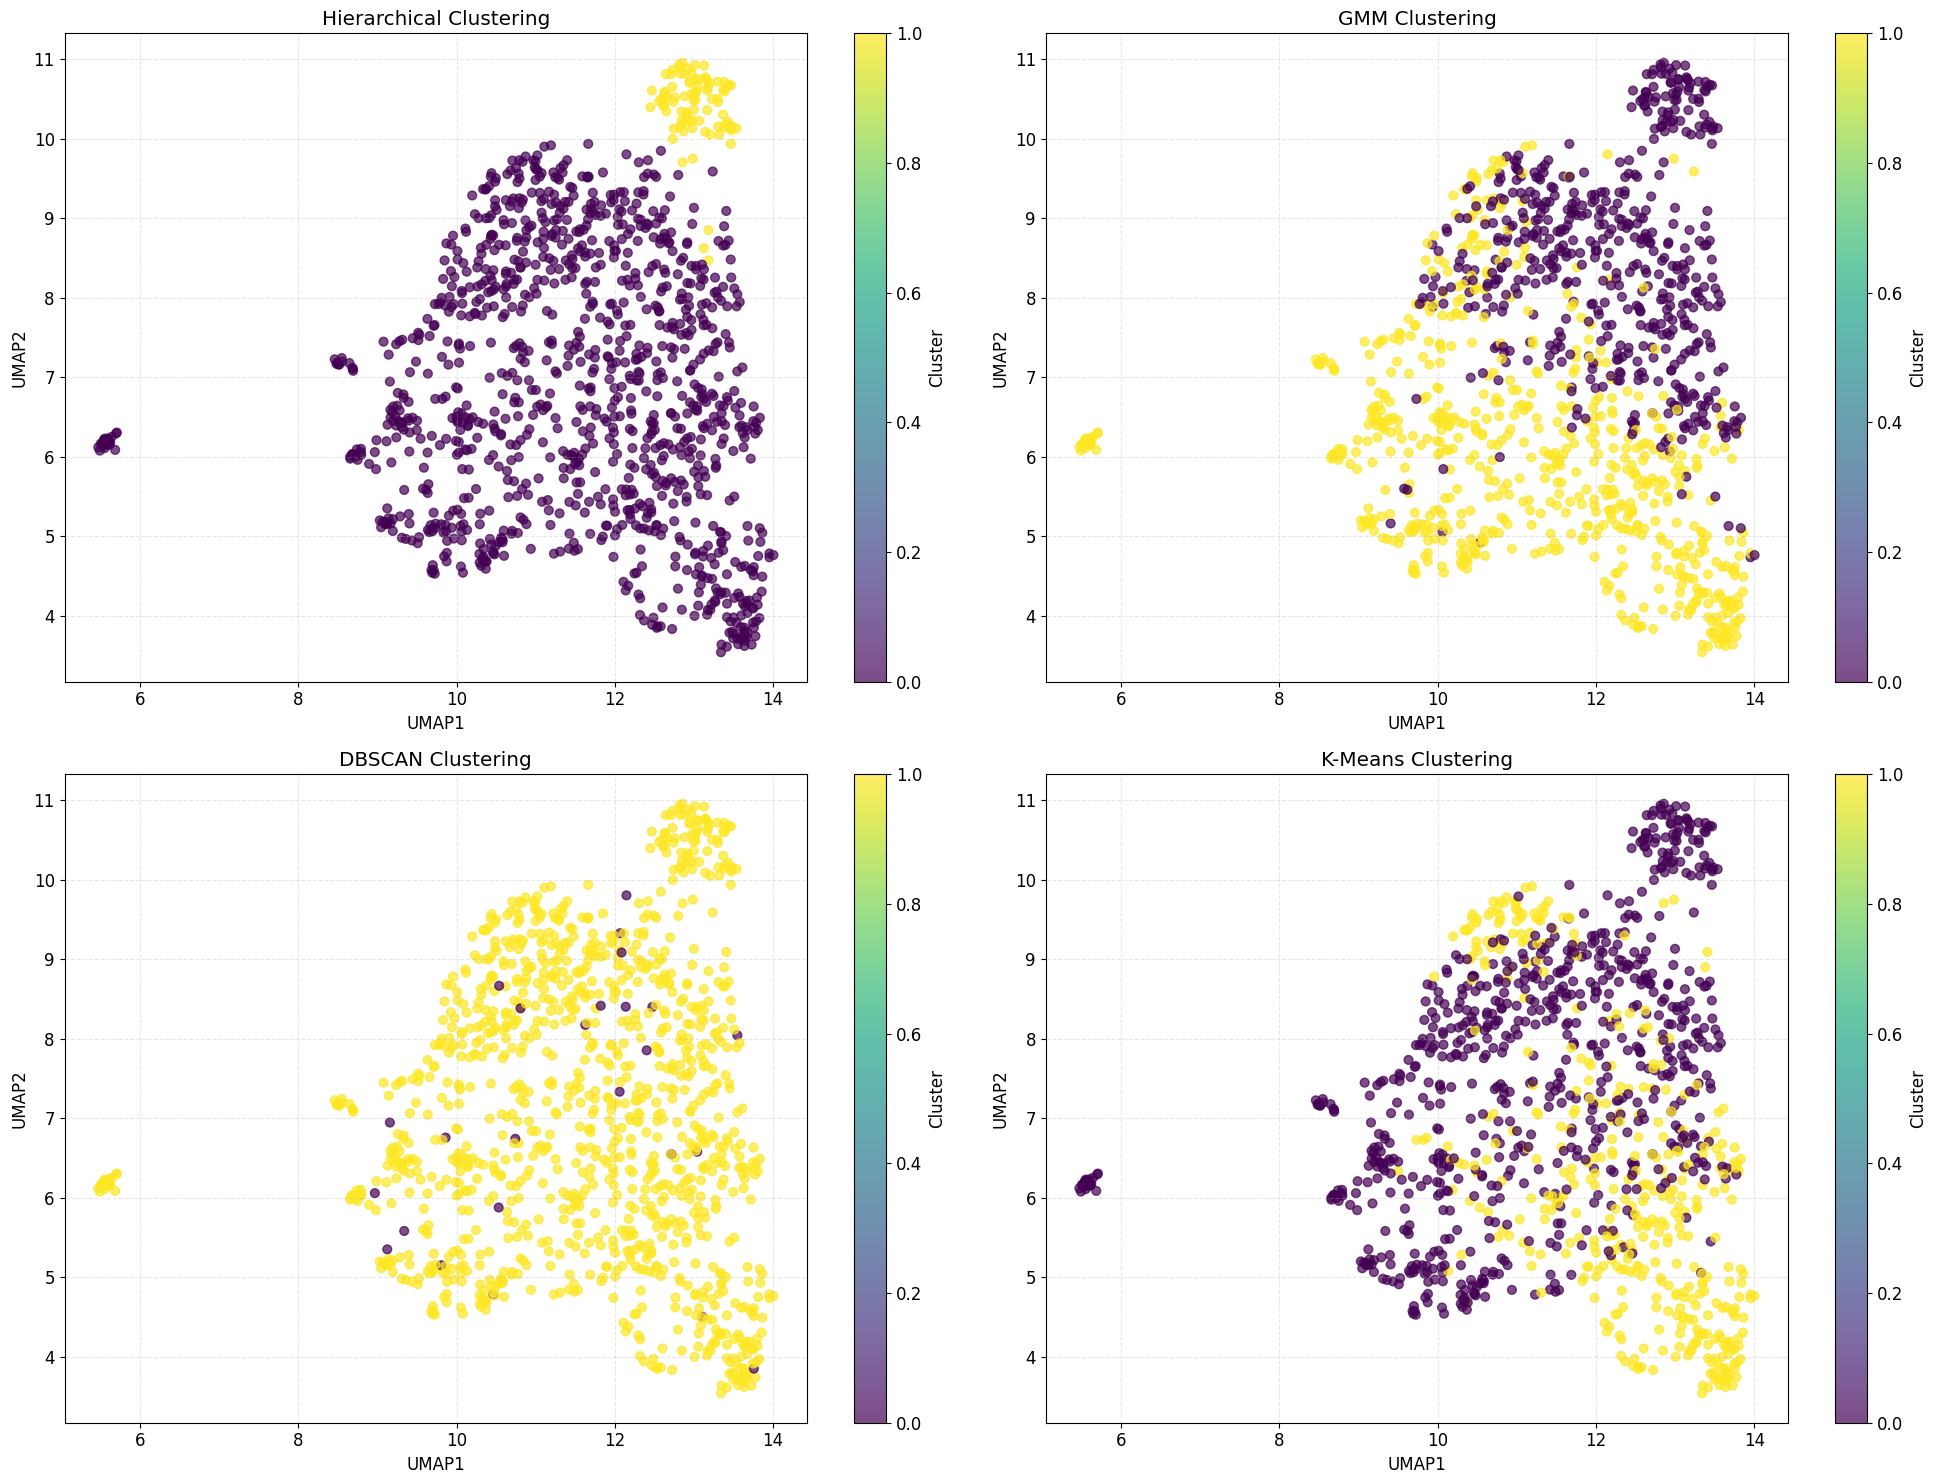


Clustering Methods Comparison:
--------------------------------------------------
Method          Accuracy   Silhouette   Time (s)  
--------------------------------------------------
Hierarchical    0.3863    -0.0005     0.4286
GMM             0.3871    0.0248     0.9362
DBSCAN          0.4425    0.2178     0.2793
K-Means         0.3524    0.0280     0.0000

Best performing method: DBSCAN with accuracy: 0.4425


In [13]:
import kneed

# Compare K-Means with other clustering algorithms
def compare_clustering_methods(data_scaled, umap_embedding, program_types):
    from sklearn.cluster import AgglomerativeClustering, DBSCAN
    from sklearn.mixture import GaussianMixture
    import time
    
    # Dictionary to store results
    results = {}
    
    # Set number of clusters
    n_clusters = 2
    
    # 1. Hierarchical Clustering
    start_time = time.time()
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(data_scaled)
    hierarchical_time = time.time() - start_time
    
    # 2. Gaussian Mixture Model
    start_time = time.time()
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(data_scaled)
    gmm_time = time.time() - start_time
    
    # 3. DBSCAN
    start_time = time.time()
    # Find a reasonable eps value based on nearest neighbors
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(data_scaled)
    distances, indices = nbrs.kneighbors(data_scaled)
    
    # Sort distances
    distances = np.sort(distances[:, 1])
    
    # Use the knee point as eps
    from kneed import KneeLocator
    knee_locator = KneeLocator(
        range(len(distances)), 
        distances, 
        S=1.0, 
        curve="convex", 
        direction="increasing"
    )
    eps = distances[knee_locator.knee] if knee_locator.knee else np.median(distances)
    
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(data_scaled)
    
    # Remap DBSCAN labels (which can be -1 for noise)
    # Treat noise points as a separate cluster
    dbscan_labels = dbscan_labels + 1  # Shift -1 to 0, 0 to 1, etc.
    dbscan_time = time.time() - start_time
    
    # Store results
    clustering_methods = {
        'Hierarchical': {
            'labels': hierarchical_labels,
            'time': hierarchical_time
        },
        'GMM': {
            'labels': gmm_labels,
            'time': gmm_time
        },
        'DBSCAN': {
            'labels': dbscan_labels,
            'time': dbscan_time
        }
    }
    
    # Add K-Means from previous analysis
    clustering_methods['K-Means'] = {
        'labels': clustering_results[n_clusters]['labels'],
        'time': 0  # We don't have timing for K-Means
    }
    
    # Visualize all methods together
    plt.figure(figsize=(20, 15))
    
    for i, (method_name, method_info) in enumerate(clustering_methods.items()):
        plt.subplot(2, 2, i+1)
        
        # Plot clusters
        scatter = plt.scatter(
            umap_embedding[:, 0],
            umap_embedding[:, 1],
            c=method_info['labels'],
            cmap='viridis',
            alpha=0.7,
            s=40
        )
        
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'{method_name} Clustering')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('clustering_methods_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate accuracy for all methods
    print("\nClustering Methods Comparison:")
    print("-" * 50)
    print(f"{'Method':<15} {'Accuracy':<10} {'Silhouette':<12} {'Time (s)':<10}")
    print("-" * 50)
    
    for method_name, method_info in clustering_methods.items():
        labels = method_info['labels']
        
        # Create binary labels for program types (Reskilling = 1, Others = 0)
        binary_program = np.where(program_types == 'Reskilling', 1, 0)
        
        # Check if we need to flip labels for better comparison
        cluster0_reskilling_count = np.sum((labels == 0) & (binary_program == 1))
        cluster0_upskilling_count = np.sum((labels == 0) & (binary_program == 0))
        
        if cluster0_upskilling_count > cluster0_reskilling_count:
            compare_labels = 1 - labels  # Flip 0->1 and 1->0
        else:
            compare_labels = labels
        
        # Calculate accuracy
        accuracy = np.mean(binary_program == compare_labels)
        
        # Calculate silhouette score if more than one cluster
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and len(unique_labels) < len(data_scaled):
            silhouette = silhouette_score(data_scaled, labels)
        else:
            silhouette = "N/A"
        
        print(f"{method_name:<15} {accuracy:.4f}    {silhouette if isinstance(silhouette, str) else silhouette:.4f}     {method_info['time']:.4f}")
    
    # Return best performing method based on accuracy
    accuracy_values = {}
    for method_name, method_info in clustering_methods.items():
        labels = method_info['labels']
        
        # Create binary labels for program types (Reskilling = 1, Others = 0)
        binary_program = np.where(program_types == 'Reskilling', 1, 0)
        
        # Check if we need to flip labels for better comparison
        cluster0_reskilling_count = np.sum((labels == 0) & (binary_program == 1))
        cluster0_upskilling_count = np.sum((labels == 0) & (binary_program == 0))
        
        if cluster0_upskilling_count > cluster0_reskilling_count:
            compare_labels = 1 - labels  # Flip 0->1 and 1->0
        else:
            compare_labels = labels
        
        # Calculate accuracy
        accuracy_values[method_name] = np.mean(binary_program == compare_labels)
    
    best_method = max(accuracy_values.items(), key=lambda x: x[1])
    
    print(f"\nBest performing method: {best_method[0]} with accuracy: {best_method[1]:.4f}")
    
    return clustering_methods

# Compare different clustering methods
clustering_methods = compare_clustering_methods(data_scaled, umap_embedding, program_types)